# TP 3  : Graph Neural Networks Architecture

**Théo Rudkiewicz, Cyriaque Rousselot**

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 110.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 103.1 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.2 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [5]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node).

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [2]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

In [ ]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [3]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [87]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Let's train this model !

In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(
    device
)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6368
F1-Score: 0.4550
Epoch 00002 | Loss: 0.5804
Epoch 00003 | Loss: 0.5618
Epoch 00004 | Loss: 0.5549
Epoch 00005 | Loss: 0.5506
Epoch 00006 | Loss: 0.5463
F1-Score: 0.5102
Epoch 00007 | Loss: 0.5424
Epoch 00008 | Loss: 0.5382
Epoch 00009 | Loss: 0.5344
Epoch 00010 | Loss: 0.5315
Epoch 00011 | Loss: 0.5290
F1-Score: 0.5229
Epoch 00012 | Loss: 0.5265
Epoch 00013 | Loss: 0.5240
Epoch 00014 | Loss: 0.5217
Epoch 00015 | Loss: 0.5194
Epoch 00016 | Loss: 0.5172
F1-Score: 0.5314
Epoch 00017 | Loss: 0.5151
Epoch 00018 | Loss: 0.5130
Epoch 00019 | Loss: 0.5109
Epoch 00020 | Loss: 0.5087
Epoch 00021 | Loss: 0.5064
F1-Score: 0.5137
Epoch 00022 | Loss: 0.5038
Epoch 00023 | Loss: 0.5015
Epoch 00024 | Loss: 0.4995
Epoch 00025 | Loss: 0.4974
Epoch 00026 | Loss: 0.4955
F1-Score: 0.5419
Epoch 00027 | Loss: 0.4936
Epoch 00028 | Loss: 0.4918
Epoch 00029 | Loss: 0.4900
Epoch 00030 | Loss: 0.4882
Epoch 00031 | Loss: 0.4865
F1-Score: 0.5552
Epoch 00032 | Loss: 0.4848
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the validation set: 0.6578


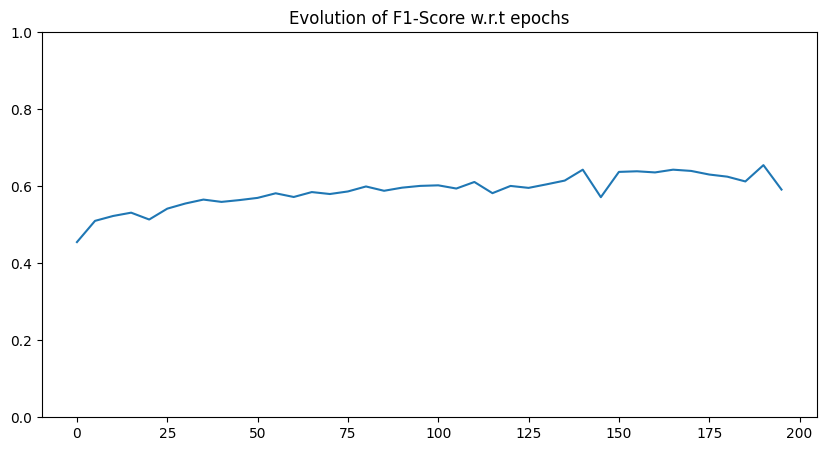

In [ ]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(basic_model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files :
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `conv_as_message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights

 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.

Intermediate question :

 Provide the script for training, and a plot of the training loss.  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define model ( in your class_model_gnn.py)
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Initialize model
model = StudentModel()

## Save the model
torch.save(model.state_dict(), "model.pth")


### This is the part we will run in the inference to grade your model
## Load the model
model = StudentModel()  # !  Important : No argument
model.load_state_dict(torch.load("model.pth", weights_only=True))
model.eval()
print("Model loaded successfully")


Model loaded successfully


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv


# Define model
class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, sigma=nn.ELU()):
        super(GATLayer, self).__init__()
        self.W = nn.Linear(in_dim, out_dim)
        self.a = nn.Linear(2 * out_dim, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.softmax = nn.Softmax(dim=1)
        self.sigma = sigma

    def forward(self, x, edge_index):
        N = x.size(0)
        h = self.W(x)  # N x out_dim

        # Initialize attention output with very negative values
        attn_output = torch.full((N, N), float('-inf')).to(x.device)

        # Compute attention only for edges in edge_index
        for i, j in edge_index.t():
            attn_input = torch.cat([h[i], h[j]], dim=0)  # 2*out_dim
            attn_output[i, j] = self.a(attn_input).squeeze(0)

        attn_output = self.leaky_relu(attn_output)
        attn_output = self.softmax(attn_output)

        # Update node embedding
        h_prime = torch.matmul(attn_output, h)
        h_prime = self.sigma(h_prime)

        return h_prime

class MultiHeadGAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads=1, concat=True):
        super(MultiHeadGAT, self).__init__()
        self.num_heads = num_heads
        self.concat = concat
        self.attention_heads = nn.ModuleList([GATLayer(in_dim, hidden_dim) for _ in range(num_heads)])
        self.out_layer = GATLayer(hidden_dim * num_heads if concat else hidden_dim, out_dim)

    def forward(self, x, adj):
        head_outputs = [head(x, adj) for head in self.attention_heads]

        if self.concat:
            x = torch.cat(head_outputs, dim=1)
        else:
            x = torch.stack(head_outputs, dim=0).mean(dim=0)

        x = self.out_layer(x, adj)

        return x

class MyGAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads=1, num_inter_layers=1, concat=True, implemented = False, dropout=0.):
        super(MyGAT, self).__init__()
        self.layers = nn.ModuleList()
        if implemented:
            Head_GAT_in = MultiHeadGAT(in_dim, hidden_dim, hidden_dim, num_heads, concat)
            Head_GAT_inter = MultiHeadGAT(hidden_dim * num_heads if concat else hidden_dim, hidden_dim, hidden_dim, num_heads, concat)
            Head_GAT_out = nn.Linear(hidden_dim * num_heads if concat else hidden_dim, out_dim)
        else:
            Head_GAT_in = GATConv(in_dim, hidden_dim, heads=num_heads, concat=concat, dropout=dropout)
            Head_GAT_inter = GATConv(hidden_dim * num_heads if concat else hidden_dim, hidden_dim, heads=num_heads, concat=concat, dropout=dropout)
            Head_GAT_out = nn.Linear(hidden_dim * num_heads if concat else hidden_dim, out_dim)

        # Add initial multi-head GAT layer
        self.layers.append(Head_GAT_in)

        # Add intermediate multi-head GAT layers
        for _ in range(num_inter_layers):
            self.layers.append(Head_GAT_inter)

        # Add final averaging GAT layer
        self.layers.append(Head_GAT_out)

        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x, adj):
        n = len(self.layers)
        for i in range(n-1):
            x = self.layers[i](x, adj)
            x = self.leaky_relu(x)
        x = self.layers[-1](x).flatten(1)
        return x


Device:  cuda
Epoch 00001 | Loss: 0.8730
F1-Score: 0.4536
Epoch 00002 | Loss: 0.5625
Epoch 00003 | Loss: 0.5531
Epoch 00004 | Loss: 0.5446
Epoch 00005 | Loss: 0.5333
Epoch 00006 | Loss: 0.5289
F1-Score: 0.4820
Epoch 00007 | Loss: 0.5252
Epoch 00008 | Loss: 0.5227
Epoch 00009 | Loss: 0.5174
Epoch 00010 | Loss: 0.5081
Epoch 00011 | Loss: 0.5012
F1-Score: 0.5037
Epoch 00012 | Loss: 0.5003
Epoch 00013 | Loss: 0.5010
Epoch 00014 | Loss: 0.4990
Epoch 00015 | Loss: 0.4918
Epoch 00016 | Loss: 0.4839
F1-Score: 0.5283
Epoch 00017 | Loss: 0.4808
Epoch 00018 | Loss: 0.4756
Epoch 00019 | Loss: 0.4690
Epoch 00020 | Loss: 0.4676
Epoch 00021 | Loss: 0.4650
F1-Score: 0.5756
Epoch 00022 | Loss: 0.4603
Epoch 00023 | Loss: 0.4511
Epoch 00024 | Loss: 0.4450
Epoch 00025 | Loss: 0.4611
Epoch 00026 | Loss: 0.4575
F1-Score: 0.5675
Epoch 00027 | Loss: 0.4503
Epoch 00028 | Loss: 0.4382
Epoch 00029 | Loss: 0.4291
Epoch 00030 | Loss: 0.4211
Epoch 00031 | Loss: 0.4165
F1-Score: 0.6084
Epoch 00032 | Loss: 0.4139
Ep

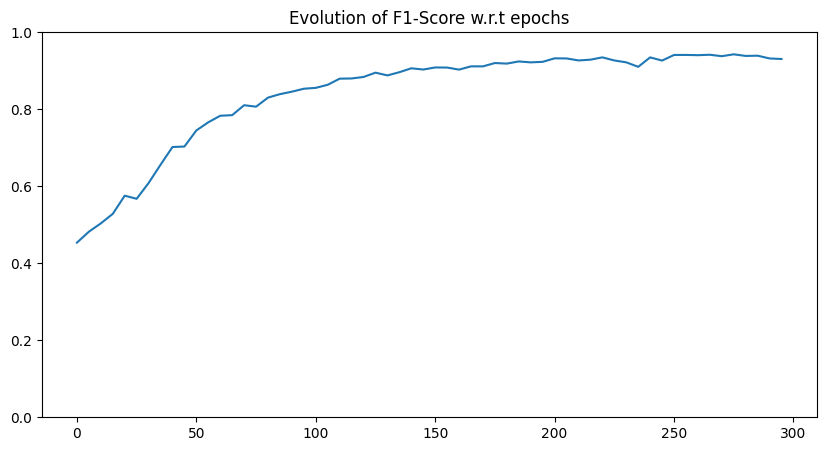

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from class_model_gnn import MyGAT

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 300

### Model parameters
in_dim = train_dataset[0].x.shape[1]
out_dim = train_dataset[0].y.shape[1]
hidden_dim = 256
num_layers = 2 # ATTENTION : 1 layer implies 1 hidden layer (originally : GAT layer + MLP layer)
heads = 4


### DEFINE THE GAT MODEL
gat_model = MyGAT(in_dim, hidden_dim, out_dim, num_inter_layers=num_layers, num_heads=heads).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, gat_model_scores = train(
    gat_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)

### Save the model
torch.save(gat_model.state_dict(), "gat_model.pth")

### F1-SCORE ON VALID DATASET
score_valid = evaluate(gat_model, loss_fcn, device, val_dataloader)
print("GAT Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, gat_model_scores)

In [6]:
from class_model_gnn import MyGAT
### Model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim = train_dataset[0].x.shape[1]
out_dim = train_dataset[0].y.shape[1]
hidden_dim = 256
num_layers = 2 # ATTENTION : 1 layer implies 1 hidden layer (originally : GAT layer + MLP layer)
heads = 4

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

# Load gat_model and do F1-score on test dataset

gat_model = MyGAT(in_dim, hidden_dim, out_dim, num_inter_layers=num_layers, num_heads=heads).to(device)
gat_model.load_state_dict(torch.load("gat_model.pth", weights_only=True))
gat_model.eval()
print("GAT Model loaded successfully")

score_test = evaluate(gat_model, loss_fcn, device, test_dataloader) 
print("GAT Model : F1-Score on the test set: {:.4f}".format(score_test))

score_valid = evaluate(gat_model, loss_fcn, device, val_dataloader)
print("GAT Model : F1-Score on the validation set: {:.4f}".format(score_valid))

GAT Model loaded successfully
GAT Model : F1-Score on the test set: 0.9591
GAT Model : F1-Score on the validation set: 0.9395


## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `conv_as_message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 3x3 kernel with stride 1 and padding 1.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)
$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ :

$$ \gamma_\Theta : x,y \mapsto y $$


**Answer Q2 :**

**Let us recall that : In a 2D convolutional layer, the output feature map $x' \in \mathbb{R}^{C' \times H' \times W'}$ is computed as:**

\begin{equation}\tag{eq1}
    x'_{i,j,c'} = \sigma \left( \sum_{c=0}^{C-1} \sum_{m=0}^{K_h-1} \sum_{n=0}^{K_w-1} \mathcal{W}_{m,n,c,c'} \cdot x_{i \cdot s_h + m - \lfloor \frac{K_h}{2} \rfloor, j \cdot s_w + n - \lfloor \frac{K_w}{2} \rfloor, c} + b_{c'} \right)
\end{equation}

**where:**

- **$x \in \mathbb{R}^{C \times H \times W}$ is the input.**
- **$x' \in \mathbb{R}^{C' \times H' \times W'}$ is the output feature map.**
- **$\mathcal{W} \in \mathbb{R}^{C' \times C \times K_h \times K_w}$ is the convolutional kernel.**
- **$b \in \mathbb{R}^{C'}$ is the bias.**
- **$K_h, K_w$ are the height and width of the kernel.**
- **$C$ and $C'$ are the number of input and output channels.**
- **$s_h, s_w$ are the stride values for height and width.**
- **$p_h, p_w$ are the padding values for height and width.**
- **$\sigma$ is an activation function.**

**We easily observe that for each $I=(i,j)$, we create a features map points $x'_{I}$ solely based on the neigbhoring pixels (neigbhors of a distance linked to the kernel sizes). Thus, we will define a graph which has pixels $x_I'$ as nodes and edges between pixels that are useful for output computation (where $I'$ is computed based on $I$ and the hyper-parameters).**

**IMPORTANT - We will reduce the assumptions made before into only those assumptions (they are definitely weaker):**
- **$K_w$ and $K_h$ are odds integers (not only $3\times3$), we need that to easily define a clear point on which we apply the kernel.**
- **$p_h \leq \lfloor \frac{K_h}{2} \rfloor$ and $p_w \leq \lfloor \frac{K_w}{2} \rfloor$ (this is not a strong assumptions because a zero-padding with higher values would pretty much be useless).**

**We will define an oriented graph where the nodes are the pixels (the features being the RGB channels) and the neighbors in the graph are pixels used in convolution.**

**We define the graph $G=(V,E,A)$ where $V=\{pixel_{ij}\;|\; (i,j)\in \{0,\cdots,H-1\}\times\{0,\cdots,W-1\}\}$ and $A$ (the Adjacency matrix) is defined as follows :**

$\forall (i,j), \,(i',j')\in \{0,\cdots,H-1\}\times\{0,\cdots,W-1\},$

\begin{align}\tag{eq2} A_{(i,j)(i',j')} = \begin{cases} 1 + (i'-i+\lfloor \frac{K_h}{2} \rfloor)K_w+j'-j+\lfloor \frac{K_w}{2} \rfloor, & \text{if } (i,j)\mathcal{R}_{conv}(i',j')  \\ 0, & \text{ otherwise } \end{cases} \end{align}

**Where we define the relation $\mathcal{R}_{conv}$ as follows :**

**$(i,j)$ and $(i',j')$ verify $(i,j)\mathcal{R}_{conv}(i',j')$ if and only if (LowBorder), (UpBorder), (Stride) and (KernelNeigbhor) hold together :**
\begin{align}
i \geq \lfloor \frac{K_h}{2} \rfloor -p_h \text{ and } j \geq \lfloor \frac{K_w}{2} \rfloor -p_w \tag{LowBorder} \\
i < H + p_h -\lfloor \frac{K_h}{2} \rfloor \text{ and } j < W + p_w -\lfloor \frac{K_w}{2} \rfloor \tag{UpBorder} \\
i + \lfloor \frac{K_h}{2} \rfloor -p_h \equiv 0 \pmod{s_h} \text{ and } j + \lfloor \frac{K_w}{2} \rfloor -p_w \equiv 0 \pmod{s_w} \tag{Stride} \\
|i-i'|\leq \lfloor \frac{K_h}{2} \rfloor \text{ and } |j-j'|\leq \lfloor \frac{K_w}{2} \rfloor \tag{KernelNeigbhor}
\end{align}

**From this we easily define $E$ : $((i,j),(i',j'))\in E$ if and only if $A_{(i,j)(i',j')} > 0$ (note that the graph is oriented).**

**Thus, we can rewrite the convolutional layer as follows : $\forall (I,J)\in \{0,\cdots,H'-1\}\times\{0,\cdots,W'-1\}$ we define the pixel equivalent as $(i,j) = (I \cdot s_h - p_h + \left\lfloor \frac{K_h}{2} \right\rfloor, J \cdot s_w - p_w + \left\lfloor \frac{K_w}{2} \right\rfloor)$**

**We introduce $ \gamma_\Theta : (x,y) \mapsto \sigma(y + b) $ and**
$$\phi_\Theta : (x_{(i_1,j_1)}, x_{(i_2,j_2)}, A_{(i_1,j_1)(i_2,j_2)}) \mapsto \left( \sum_{c=0}^{C-1} \mathcal{W}_{m,n,c,c'} \cdot x_{(i_2, j_2), c} \right)_{c'\in \{0,\cdots, C'-1\}}$$
**Where $m = \left\lfloor \frac{A_{(i_1,j_1)(i_2,j_2)}-1}{K_w} \right\rfloor$ and $n = A_{(i_1,j_1)(i_2,j_2)} -1 - m \cdot K_w$**

**Therefore, we have :**
$$\mathbf{x}_{(I,J)}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{(i,j)},\sum\limits_{(i',j') \in \mathcal{N}((i,j))}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{(i,j)},\mathbf{x}_{(i',j')},\mathbf{A}_{(i,j)(i',j')} \right) \right),$$

**Recall that $(i,j)$ is defined based on $(I,J)$.**

In [3]:
import torch
import torch_geometric

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [23]:
from torch_geometric.data import Batch

def relation_conv(H, W, Kh, Kw, ph, pw, sh, sw, i, j, ni, nj):
    """
    Computes the relation convolution between two pixels.

    Arguments:
    ----------
    Kh : int
        Height of the kernel.
    Kw : int
        Width of the kernel.
    ph : int
        Padding height.
    pw : int
        Padding width.
    sh : int
        Stride height.
    sw : int
        Stride width.
    i : int
        Row index of the first pixel.
    j : int
        Column index of the first pixel.
    ni : int
        Row index of the second pixel.
    nj : int
        Column index of the second pixel.

    Returns:
    --------
    bool
        Return True if the two verify Rconv defined in Question 2.
    """
    low_border = (i >= Kh // 2 - ph) and (j >= Kw // 2 - pw)
    up_border = (i < H + ph - Kh // 2) and (j < W + pw - Kw // 2)
    stride = ((i + Kh // 2 - ph) % sh == 0) and ((j + Kw // 2 - pw) % sw == 0)
    kernel_neighbor = (abs(i - ni) <= Kh // 2) and (abs(j - nj) <= Kw // 2) # Should always be True with the current definition of ni and nj

    return low_border and up_border and stride and kernel_neighbor

def image_to_graph(
    image: torch.Tensor, conv2d: torch.nn.Conv2d | None = None, flow: str = "source_to_target"
) -> torch_geometric.data.Data:
    """
    Converts an image tensor to a PyTorch Geometric Data object.
    COMPLETE

    Arguments:
    ----------
    image : torch.Tensor
        Image tensor of shape (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None
        Is used to determine the size of the receptive field.

    Returns:
    --------
    torch_geometric.data.Data
        Graph representation of the image.
    """
    batch = True
    Kh, Kw = conv2d.kernel_size[0], conv2d.kernel_size[1]
    ph, pw = conv2d.padding[0], conv2d.padding[1]
    sh, sw = conv2d.stride[0], conv2d.stride[1]
    if conv2d is not None:
        assert Kh % 2 == 1 and Kw % 2 == 1, "Expected odd kernel sizes."
        assert ph <= Kh // 2 and pw <= Kw // 2, "Padding should be less than or equal to half of the kernel size, no need for more."
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
        batch = False
    N, C, H, W = image.shape
    R_conv = lambda i, j, ni, nj: relation_conv(H, W, Kh, Kw, ph, pw, sh, sw, i, j, ni, nj)

    graphs = []

    for n in range(N):
        nodes = []
        edges = []
        edge_attrs = []

        for i in range(H):
            for j in range(W):
                node_index = i * W + j
                nodes.append(image[n, :, i, j])

                for di in range(-Kh // 2, Kh // 2 + 1):
                    for dj in range(-Kw // 2, Kw // 2 + 1):
                        ni, nj = i + di, j + dj
                        verify = ni >= 0 and ni < H and nj >= 0 and nj < W
                        if R_conv(i, j, ni, nj) :
                            if verify:
                                neighbor_index = ni * W + nj
                                edge_value = 1 + (ni - i + Kh // 2) * Kw + nj - j + Kw // 2 # 1 + (i'-i+\lfloor \frac{K_h}{2} \rfloor)K_w+j'-j+\lfloor \frac{K_w}{2} \rfloor
                                if flow == "source_to_target":
                                    edges.append([neighbor_index, node_index])
                                elif flow == "target_to_source":
                                    edges.append([node_index, neighbor_index])
                                else:
                                    raise ValueError("flow should be 'source_to_target' or 'target_to_source'")
                                edge_attrs.append(edge_value)
        image_size = torch.zeros(C)
        if C > 1:
            image_size[0] = H
            image_size[1] = W
        else:
            image_size[0] = H
        nodes.append(image_size)
        nodes = torch.stack(nodes)
        edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attrs = torch.tensor(edge_attrs, dtype=torch.long).unsqueeze(1)

        data = torch_geometric.data.Data(x=nodes, edge_index=edges, edge_attr=edge_attrs)
        graphs.append(data)
    if batch:
        print("Image to Graph - Batch image mode with {} images".format(N))
        batch_graphs = Batch.from_data_list(graphs)
    else:
        print("Image to Graph - Single image mode")
        batch_graphs = graphs[0]

    return batch_graphs

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [80]:
def graph_to_image(
    data, height: int | None = None, width: int | None = None, conv2d: torch.nn.Conv2d | None = None, verbose: bool = True
) -> torch.Tensor:
    """
    Converts a graph representation of an image to an image tensor.

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the image.
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None

    Returns:
    --------
    torch.Tensor
        Image tensor of shape (C, H, W).
    """
    if conv2d is None:
        conv2d = torch.nn.Conv2d(C, C, kernel_size=3, padding=1, stride=1)
    Kh, Kw = conv2d.kernel_size[0], conv2d.kernel_size[1]
    ph, pw = conv2d.padding[0], conv2d.padding[1]
    sh, sw = conv2d.stride[0], conv2d.stride[1]
    if conv2d is not None:
        assert Kh % 2 == 1 and Kw % 2 == 1, "Expected odd kernel sizes."
        assert ph <= Kh // 2 and pw <= Kw // 2, "Padding should be less than or equal to half of the kernel size, no need for more."

    if isinstance(data, torch_geometric.data.Batch):
        N = data.num_graphs
        if verbose:
            print("Generating a batch of images with batch_size = ", N)
        C, H, W = data.x.shape[1], height, width
        list_of_graphs = data.to_data_list()
        if H is None or W is None:
            if C > 1:
                H, W = int(list_of_graphs[0].x[-1][0].item()), int(list_of_graphs[0].x[-1][1].item())
            else:
                H = int(list_of_graphs[0].x[-1].item())
                W = data.num_nodes // N // H
        images = torch.zeros((N, C, H, W))

        for n in range(N):
            graph = list_of_graphs[n]
            if H*W != graph.x.shape[0] - 1:
                raise ValueError("It seems that the batch of images does not have the same sizes.")
            for i in range(H):
                for j in range(W):
                    node_index = i * W + j
                    images[n, :, i, j] = graph.x[node_index]
    elif isinstance(data, torch_geometric.data.Data):
        if verbose:
            print("Generating a single image")
        C, H, W = data.x.shape[1], height, width
        if H is None or W is None:
            if C > 1:
                H, W = int(data.x[-1][0].item()), int(data.x[-1][1].item())
            else:
                H = int(data.x[-1].item())
                W = data.num_nodes // H
        images = torch.zeros((C, H, W))

        for i in range(H):
            for j in range(W):
                node_index = i * W + j
                images[:, i, j] = data.x[node_index]
    else:
        if verbose:
            print("Assuming Data.x has been provided -> No graph batch or single graph detected.")
        C, H, W = data.shape[1], height, width
        if H is None or W is None:
            if C > 1:
                H, W = int(data[-1][0].item()), int(data[-1][1].item())
            else:
                raise ValueError("Height and Width should be provided to tell wether a Tensor is a batch or a single image.")
        N = data.shape[0] // (H * W)
        if N != 1:
            if verbose:
                print("Assuming a batch of images has been provided with batch_size = ", N)
            images = torch.zeros((N, C, H, W))
            for n in range(N):
                for i in range(H):
                    for j in range(W):
                        node_index = i * W + j
                        images[n, :, i, j] = data[node_index + n * (H * W) + n]
        else:
            if verbose:
                print("Generating a single image")
            C, H, W = data.shape[1], height, width
            if H is None or W is None:
                H, W = int(data[-1][0].item()), int(data[-1][1].item())
            images = torch.zeros((C, H, W))

            for i in range(H):
                for j in range(W):
                    node_index = i * W + j
                    images[:, i, j] = data[node_index]

    return images


#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [81]:
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=7, padding=1, stride=1)
image = torch.randn(1, 2, 8, 9)
g_image = image_to_graph(image, ref_conv)
print("Graph data object: ", g_image)
print("Graph data object x: ", g_image.x.shape)
reconstructed_image = graph_to_image(g_image.x, 8, 9, ref_conv)
assert torch.allclose(image, reconstructed_image)
print("\n   Conversion functions are correct.")

Image to Graph - Batch image mode with 1 images
Graph data object:  DataBatch(x=[73, 2], edge_index=[2, 858], edge_attr=[858, 1], batch=[73], ptr=[2])
Graph data object x:  torch.Size([73, 2])
Assuming Data.x has been provided -> No graph batch or single graph detected.
Generating a single image

   Conversion functions are correct.


### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism.
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [82]:
def compute_output_size(H, W, Kh, Kw, ph, pw, sh, sw):
    H_prime = (H + 2 * ph - Kh) // sh + 1
    W_prime = (W + 2 * pw - Kw) // sw + 1
    return H_prime, W_prime

def compute_output_index(i, j, Kh, Kw, ph, pw, sh, sw):
    i_prime = (i - Kh // 2 + ph) // sh
    j_prime = (j - Kw // 2 + pw) // sw
    return i_prime, j_prime

class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d, flow="source_to_target", implemented=False, direct=False):
        super().__init__(aggr='sum')  # "Add" aggregation.
        self.Kh, self.Kw = conv2d.kernel_size
        self.ph, self.pw = conv2d.padding
        self.sh, self.sw = conv2d.stride
        self.in_channels = conv2d.in_channels
        self.out_channels = conv2d.out_channels
        self.weight = conv2d.weight # Shape: (out_channels, in_channels, Kh, Kw)
        self.bias = conv2d.bias # Shape: (out_channels)
        self.conv2d = conv2d
        self.H = None
        self.W = None
        self.H_prime = None
        self.W_prime = None
        self.edge_index = None
        self.num_graphs = None
        self.flow = flow
        self.implemented = implemented # If True, the propagation method is implemented, otherwise it is the basic propagate function.
        self.direct = direct # If True, the output is computed directly with formula given in Q2.
        self.compute_out_size = lambda H, W: compute_output_size(H, W, self.Kh, self.Kw, self.ph, self.pw, self.sh, self.sw)
        self.compute_out_index = lambda i, j: compute_output_index(i, j, self.Kh, self.Kw, self.ph, self.pw, self.sh, self.sw)

    def forward(self, data):
        if isinstance(data, torch_geometric.data.Batch):
            self.num_graphs = data.num_graphs
            list_of_graphs = data.to_data_list()
        else:
            self.num_graphs = 1
            list_of_graphs = [data]

        outputs = []
        for graph in list_of_graphs:
            x, edge_index, edge_attr = graph.x, graph.edge_index, graph.edge_attr
            self.edge_index = edge_index
            if self.in_channels > 1:
                H, W = int(x[-1][0].item()), int(x[-1][1].item())
            else:
                H = int(x[-1].item())
                W = graph.num_nodes // self.num_graphs // H
            self.H, self.W = H, W
            x = x[:-1]
            self.H_prime, self.W_prime = self.compute_out_size(H, W)
            if self.implemented and not self.direct:
                out = self.propagation(edge_index, x=x, edge_attr=edge_attr, flow=self.flow)
                out = self.transform_output(out)
            elif not self.implemented and not self.direct:
                out = self.propagate(edge_index, x=x, edge_attr=edge_attr, flow=self.flow)
                out = self.transform_output(out)
            else:
                out = self.compute_out_directly(x, edge_attr)
            outputs.append(out)
        if self.direct :
            if self.num_graphs == 1:
                return outputs[0]
            return torch.stack(outputs).view(self.num_graphs, outputs[0].shape[0], outputs[0].shape[1], outputs[0].shape[2]) # (num_graphs, out_channels, H', W')
        else :
            return torch.stack(outputs).view(self.num_graphs * outputs[0].shape[0], outputs[0].shape[1])

    def message(self, x_j: torch.Tensor, x_i: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        For each edge e = (u, v) in the graph indexed by i,
        the message trough the edge e (ie from node u to node v)
        should be returned as the i-th line of the output tensor.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the source node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size COMPLETE)
        """
        if self.bias is not None:
            if self.flow == "source_to_target":
                node_counts = torch.bincount(self.edge_index[1, :], minlength=self.edge_index.max().item() + 1)
                node_counts = node_counts[self.edge_index[1, :]]
            elif self.flow == "target_to_source":
                node_counts = torch.bincount(self.edge_index[0, :], minlength=self.edge_index.max().item() + 1)
                node_counts = node_counts[self.edge_index[0, :]]
        C_prime, nb_edges = self.out_channels, x_j.shape[0]
        phi = torch.zeros((nb_edges, C_prime))
        for idx in range(nb_edges):
            edge_value = int(edge_attr[idx]) - 1
            m, n = edge_value // self.Kw, edge_value % self.Kw
            for c_prime in range(C_prime):
                for c in range(self.in_channels):
                    phi[idx, c_prime] += x_j[idx, c] * self.weight[c_prime, c, m, n]
                if self.bias is not None:
                    phi[idx, c_prime] += self.bias[c_prime] * (1/node_counts[idx])
        return phi

    def transform_output(self, out):
        """
        Transforms the output of the message passing to the expected shape -> Indeed, we get (num_nodes, out_channels) as shape.
        But for convolution many of those nodes are useless to us. We want to get the output in the shape (H'*W', out_channels).
        """
        output = torch.zeros((self.H_prime * self.W_prime + 1, self.out_channels))
        if self.flow == "source_to_target":
            unique_nodes = torch.unique(self.edge_index[1, :])
        elif self.flow == "target_to_source":
            unique_nodes = torch.unique(self.edge_index[0, :])
        for idx in unique_nodes:
            i_prime, j_prime = self.compute_out_index(idx // self.W, idx % self.W)
            output[i_prime * self.W_prime + j_prime, :] = out[idx]
        if self.out_channels > 1:
            output[-1, :2] = torch.tensor([self.H_prime, self.W_prime])
        else:
            output[-1, :1] = torch.tensor([self.H_prime])
        return output
    
    def propagation(self, edge_index, x=None, edge_attr=None, flow="source_to_target"):
        """
        My own implemented propagate function : propagates messages along the edges of the graph.
        You can use it by changing the preset parameter 'implemented' to True.
        """
        if flow == "source_to_target":
            x_j = x[edge_index[0]]
            x_i = x[edge_index[1]]
        elif flow == "target_to_source":
            x_j = x[edge_index[1]]
            x_i = x[edge_index[0]]
        else:
            raise ValueError("Flow should be either 'source_to_target' or 'target_to_source'.")
        message = self.message(x_j, x_i, edge_attr)
        assert message.shape == (edge_index.shape[1], self.out_channels)
        out = torch.zeros((x.shape[0], self.out_channels))
        for idx in range(edge_index.shape[1]):
            i, j = int(edge_index[0, idx]), int(edge_index[1, idx])
            if flow == "source_to_target":
                out[j] += message[idx]
            elif flow == "target_to_source":
                out[i] += message[idx]
        return out
    
    def compute_out_directly(self, x: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the output of the layer directly without message passing.
        """
        C_prime, H_prime, W_prime = self.out_channels, self.H_prime, self.W_prime
        Final = torch.zeros((C_prime, H_prime, W_prime))
        for idx in range(self.edge_index.shape[1]):
            if self.flow == "source_to_target":
                i, j = int(self.edge_index[1, idx]), int(self.edge_index[0, idx])
            elif self.flow == "target_to_source":
                i, j = int(self.edge_index[0, idx]), int(self.edge_index[1, idx])
            i_prime, j_prime = self.compute_out_index(i // self.W, i % self.W)
            edge_value = int(edge_attr[idx]) - 1
            m, n = edge_value // self.Kw, edge_value % self.Kw
            for c_prime in range(C_prime):
                for c in range(self.in_channels):
                    Final[c_prime, i_prime, j_prime] += x[j, c] * self.weight[c_prime, c, m, n]
                if self.bias is not None:
                    Final[c_prime, i_prime, j_prime] += self.bias[c_prime]

        return Final

## Test example

In [83]:
N = 1
c = 1
h = 20
w = 15

kernel_size = 7
padding = 3
stride = 2
c_prime = 5

bias = True

# You can choose the flow of the graph as you prefer (source_to_taget implies that the target node is the center on which the kernel is applied)
flow = "source_to_target"
flow = "target_to_source"

ref_conv = torch.nn.Conv2d(c, c_prime, kernel_size=kernel_size, padding=padding, stride=stride, bias=bias)
image = torch.randn(c, h, w)

g_image = image_to_graph(image, ref_conv, flow=flow)
print("Graph data object: ", g_image)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

y_th = ref_conv(image)

conv_mp = Conv2dMessagePassing(ref_conv, implemented=False, flow=flow) # Original Message Passing method from pytorch geometric (propagate function)
graphic_image_1 = conv_mp(g_image)

conv_mp = Conv2dMessagePassing(ref_conv, implemented=True, flow=flow) # My Message Passing method (propagation function implemented)
graphic_image_2 = conv_mp(g_image)

h_prime, w_prime = compute_output_size(h, w, kernel_size, kernel_size, padding, padding, stride, stride) # To reconstruct the image in case the kernel changed the size of the output.

reconstructed_image_1 = graph_to_image(graphic_image_1, h_prime, w_prime, ref_conv, verbose=False)
reconstructed_image_2 = graph_to_image(graphic_image_2, h_prime, w_prime, ref_conv, verbose=False)

print("\n  FLOW: ", flow)
assert torch.allclose(y_th, reconstructed_image_1, atol=1e-4)
print("\n   Message Passing Convolution is correct.")

assert torch.allclose(y_th, reconstructed_image_2, atol=1e-4)
print("\n   My Implemented Message Passing Convolution is correct.")


Image to Graph - Single image mode
Graph data object:  Data(x=[301, 1], edge_index=[2, 3072], edge_attr=[3072, 1])

  FLOW:  target_to_source

   Message Passing Convolution is correct.

   My Implemented Message Passing Convolution is correct.


### All the test together without having to run the rest of the notebook :

In [1]:
import torch
import torch_geometric
from torch_geometric.data import Batch
from conv_as_message_passing import image_to_graph, graph_to_image, compute_output_size, Conv2dMessagePassing

##################################################################################################################################
print("-"*50 + "Test Image to Graph to Image" + "-"*50)

ref_conv = torch.nn.Conv2d(5, 7, kernel_size=7, padding=1, stride=1)
image = torch.randn(1, 2, 8, 9)
g_image = image_to_graph(image, ref_conv)
print("Graph data object: ", g_image)
print("Graph data object x: ", g_image.x.shape)
reconstructed_image = graph_to_image(g_image.x, 8, 9, ref_conv)
assert torch.allclose(image, reconstructed_image)
print("\n   Conversion functions are correct.")

##################################################################################################################################
print("-"*50 + "Test Message Passing Convolution" + "-"*50)

N = 1
c = 1
h = 15
w = 15

kernel_size = 7
padding = 3
stride = 2
c_prime = 5

bias = True

# You can choose the flow of the graph as you prefer (source_to_taget implies that the target node is the center on which the kernel is applied)
flow = "source_to_target"
flow = "target_to_source"

ref_conv = torch.nn.Conv2d(c, c_prime, kernel_size=kernel_size, padding=padding, stride=stride, bias=bias)
image = torch.randn(c, h, w)

g_image = image_to_graph(image, ref_conv, flow=flow)
print("Graph data object: ", g_image)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

y_th = ref_conv(image)

conv_mp = Conv2dMessagePassing(ref_conv, implemented=False, flow=flow) # Original Message Passing method from pytorch geometric (propagate function)
graphic_image_1 = conv_mp(g_image)

conv_mp = Conv2dMessagePassing(ref_conv, implemented=True, flow=flow) # My Message Passing method (propagation function implemented)
graphic_image_2 = conv_mp(g_image)

h_prime, w_prime = compute_output_size(h, w, kernel_size, kernel_size, padding, padding, stride, stride) # To reconstruct the image in case the kernel changed the size of the output.

reconstructed_image_1 = graph_to_image(graphic_image_1, h_prime, w_prime, ref_conv, verbose=False)
reconstructed_image_2 = graph_to_image(graphic_image_2, h_prime, w_prime, ref_conv, verbose=False)

print("\n  FLOW: ", flow)
assert torch.allclose(y_th, reconstructed_image_1, atol=1e-4)
print("\n   Message Passing Convolution is correct.")

assert torch.allclose(y_th, reconstructed_image_2, atol=1e-4)
print("\n   My Implemented Message Passing Convolution is correct.")

/home/bernas/.pyenv/versions/3.11.0/envs/MVA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------------------------------------------------Test Image to Graph to Image--------------------------------------------------
Image to Graph - Batch image mode with 1 images
Graph data object:  DataBatch(x=[73, 2], edge_index=[2, 858], edge_attr=[858, 1], batch=[73], ptr=[2])
Graph data object x:  torch.Size([73, 2])
Assuming Data.x has been provided -> No graph batch or single graph detected.
Generating a single image

   Conversion functions are correct.
--------------------------------------------------Test Message Passing Convolution--------------------------------------------------
Image to Graph - Single image mode
Graph data object:  Data(x=[226, 1], edge_index=[2, 2304], edge_attr=[2304, 1])

  FLOW:  target_to_source

   Message Passing Convolution is correct.

   My Implemented Message Passing Convolution is correct.
